# ASTR3110 Tutorial 10: CNNs
Tutorial 10 of the 'Data Science Techniques in Astrophysics' course at Macquarie University.

## Learning outcomes from this tutorial

 * Learn how to setup data to input into a convolutional neural network.
 * Learn how to build a convolutional neural network in the Keras framework.
 * Create diagnostic graphs and reports for a CNN to understand how well the training went.
 * Use a saved model to make a prediction for an image.


## Setup for Google Drive

Today we will be operating on a dataset of animal images, so start by linking to your Google drive. The dataset is available at this link: [[animals.tar.gz](https://drive.google.com/file/d/1dEdDPCg9_TkDEvyLgHDrEFYhRVgakt99/view?usp=sharing)]. Please download to your Google drive and then follow the below directions to store the data in the local Colab directory in which you are running your notebook:

```
# Link to Google drive
from google.colab import drive
drive.mount('/content/gdrive')

#Copy animals.tar.gz to local directory (note the last dot means copy into the current directory)
!cp gdrive/'My Drive'/animals.tar.gz .

#make a DATA directory
!mkdir DATA

# Unpack the dataset
!tar -xzf animals.tar.gz

#Move the new folder into your DATA directory
!mv animals DATA/
```

Note that the local Colab directory may not save these datafiles after you close down your session.

## Setup for Colab

Today we will be running CNNs, which can be slow when using CPUs to do the crunching, but using a GPU can speed things up substantially. It is recommended that you run this lab using Colab, and set up the notebook to utilize GPU acceleration. To do this, click the 'Edit' button at top left of the window, then 'Notebook Settings', then select 'GPU' from the 'Hardware accelerator' dropdown menu.

## <font color=red>  THE CODE THAT FOLLOWS WAS EXECUTED LOCALLY ON MY LAPTOP. IF RUNNING ON COLAB, YOU WILL NEED TO PERFORM THE ABOVE AND CHANGE SOME OF THE PATHS BELOW, WHICH POINT TO DIRECTORIES ON MY LAPTOP!</font>

## Quick overview of CNNs

For a quick explanation of how a CNN works see [here](https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac), [here](https://www.cs.ryerson.ca/~aharley/vis/conv/) or [here](https://arxiv.org/abs/1511.08458). For a free detailed course with deep mathematical background, see [http://cs231n.stanford.edu/](http://cs231n.stanford.edu/).

In [1]:
# Import necessary modules
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
#cv2 is a module that uses OpenCV, which is a computer vision package.
#We'll be using a few of the image maniputation and I/O tools.

## Accessing the data

In this dataset the train-validation-test split has already been done, so we just need to read in the images in each directory and put them into the format expected by the CNN.

The data are in the "animals" directory with images sorted into sub-directories that are split into test, train, valid directories, each with subdifrectories for each of the classes (cat, dog, panda). That is:

```
animals/
├── test
│   ├── cat
│   ├── dog
│   └── panda
├── train
│   ├── cat
│   ├── dog
│   └── panda
└── valid
    ├── cat
    ├── dog
    └── panda
```

In [6]:
# Create the paths to the three datasets
dataDir = os.path.join("../../","animals")#os.path.join uses operating-system-specific path joins.
trainPath = os.path.join(dataDir, "train")
validPath = os.path.join(dataDir, "valid")
testPath = os.path.join(dataDir, "test")
print(trainPath)

../../animals/train


We can use [glob](https://docs.python.org/3/library/glob.html) to return a list of all of the images, which can then be used to read our data in.

In [7]:
import glob

# Get the paths to all the images. Glob uses unix-style pattern matching and path expansion. 
#If on windows, you might need to set some specific prameters -- beware!.
trainPaths = glob.glob(trainPath+'/*/*.jpg') #get all of the images in the train directoty
validPaths = glob.glob(validPath+'/*/*.jpg') #likewise for valid
testPaths = glob.glob(testPath+'/*/*.jpg')   #and test

# Print an example
print(len(trainPaths))
print(trainPaths[1])

3500
../../animals/train/cat/cat.952.jpg


Let's take a look at the images and see what needs to be done to get them into the required format.

(375, 499, 3)
Minimum pix value = 0
Maximum pix value = 255


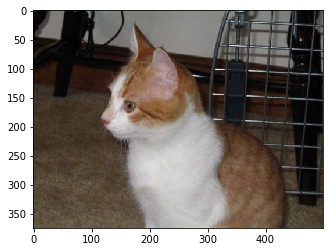

In [8]:
image = cv2.imread(trainPaths[1])
print(image.shape)
print('Minimum pix value =', np.nanmin(image))
print('Maximum pix value =', np.nanmax(image))
plt.imshow(np.flip(image,axis=2)); #cv2 reads in images as BRG, not RGB so need to flib


The images are RGB colour images, with different widths and heights, and pixel range 0 to 255. We need to loop over each of the lists, read in each image, normalise to 0-1, and resize onto a consistent size. We also need to generate the label for each image using the pathname and some tricky string manipulation.

In [9]:
#make a function that takes in a list of paths to images, and returns array with image and label. Also, 
#normalise the image
def process_image(files):
    labels=[]
    data=[]
    #print(files)
    for f in files:
        #cv2 functions operate on the 3 channels, so we don't need to run the following commands separately
        #for each channel.
        image = cv2.imread(f)/255. #read in the image using cv2's imread and normalise
        #also use cv2 resize function to 100x100 pixel images
        image_resize=cv2.resize(image,(100,100))
        #print(image.shape)
        label=f.split(os.path.sep)[-2]#splits the path based on the '/' separator (for unix style systems)
        
        #append image and label
        labels.append(label)
        data.append(image_resize)
    return(np.array(data), np.array(labels))

In [10]:
cv2.resize?

In [11]:
dataTrain,labelsTrain = process_image(trainPaths)
dataTest,labelsTest = process_image(testPaths)
dataValid,labelsValid = process_image(validPaths)

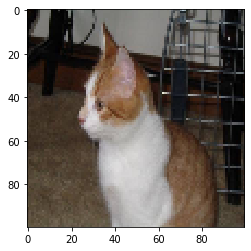

In [12]:
plt.imshow(np.flip(dataTrain[1],axis=2));

In [13]:
dataTrain.shape

(3500, 100, 100, 3)

Count the number of images in each dataset.

In [14]:
# Count the number of train, valid and test images
# ALT: trainImgPaths = list(paths.list_images(trainPath))
nTrainImg = dataTrain.shape[0]
nValidImg = dataValid.shape[0]
nTestImg = dataTest.shape[0]
print("{:d} training images.".format(nTrainImg))
print("{:d} validation images.".format(nValidImg))
print("{:d} test images.".format(nTestImg))

3500 training images.
1000 validation images.
500 test images.


We also need to make one-hot binarized labels like we did for the ANNs last week:

In [15]:
from sklearn.preprocessing import LabelBinarizer

# Convert to one-hot vectors -- might be better to not overwrite the original labels?
labelsTrain = LabelBinarizer().fit_transform(labelsTrain)
labelsValid = LabelBinarizer().fit_transform(labelsValid)
labelsTest = LabelBinarizer().fit_transform(labelsTest)
labelsTrain


array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

## Building the CNN

Now it is time to build the model. Like the ANN, we create a sequential stack of layers. However, these layers accept 3D images with a width, height and depth. CNNs also tend to have repeating blocks of layers that do:

```
Convolution -> Activation - > Binning (downsize images)
```

The convolutional layer processess the image by convolving it with a number of small filters (usually 3x3). These filters start out as noise, but are changed by the training process to detect differet 'textures' in the images. 

The binning layer we use here is called ```MaxPooling``` and shrinks the resolution of the output by 1/2 (see [here](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling)). So as the image passes through the network it is reduced in size and the relative scale of the filters changes.

Let's define simple network. The CNN accepts an array of 3D images (compare this to the ANN, which accepts an array of flattened 1D vectors).

In [16]:
from keras.models import Sequential #again building a sequential model, where input images flow through the 
                                    #achitecture in a linear way from start to finish. Can build more complicated 
                                    #architectures with multiple outputs etc.
from keras.layers.convolutional import Conv2D #conv2d sets up main part of the layers, i.e., the 2D neurons
from keras.layers.convolutional import MaxPooling2D #as we go through the network, MaxPooling bins up the pixels
from keras.layers.core import Flatten  #for CNNS, need to flatten the final layer to get a 1D output --  like np.flatten
from keras.layers.core import Activation #out activation layer -- last time used sigmoid, 
                                         #way that the output of neurons is scaled
from keras.layers.core import Dense #Dense we've met before, it's where all neurons in a layer are connected to the 
                                    #next layer. AKA "fully connected" layers.
from keras.layers.core import Dropout #dropout will help to avoid overfitting by randomly "dropping" connnections
                                      #between dense layers during the fitting process. This introduces some noise to 
                                      #the process, and avoids overfitting of the training data. Generally set prob=0.5
                                      #so that 50% of connections are randomly dropped in each mini-batch.
from keras import backend as K

#Now we can start to build our model.
# Initialize the model and channel order
model = Sequential()
#set up our input parameters
size=dataTrain.shape[1]#gives the input image size -- here we have images withthe same width & height, so only specify
                       #one dimension.
inputShape = (size, size, 3) #define the image shape -- channels last in this case.

#various ways to define the image shape in the network. The below just double checks
#what the "backend" is doing. The backend is just where all of the complicated tensor/matrix 
#operations take place, and TensorFlow is just one backend that keras can use.
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3, size, size)
    chanDim = 1
    
#build a simple CNN architecture that has 3 convolution layers, one fully connected (dense) layer, and an output layer

#show the commented architecture first...

# First CONV(32) => RELU => POOL(2) layer set 
model.add(Conv2D(32, (3, 3), input_shape=inputShape)) #32 convolutional neurons, learns set of (3,3) convolution filters
model.add(Activation('relu')) #Heaps of different activation shapes that can be used, but "rectified linear unit 
                              #(ReLu)" is good for this purpose. 
        #see https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second CONV(32) => RELU => POOL(2) layer set
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third CONV(64) => RELU => POOL(2) layer set
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# FC(64) => RELU => DROP(0.5)
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))#again, helps with overfitting by randomly discinnecting layers during fitting. Adds noise and
                       # bsically tricks the fitting to be more general than the training set allows. 

# Softmax classifier -- gives the probabilities for the different classes (3 here).
nClasses=3
model.add(Dense(nClasses))
model.add(Activation('softmax'))

Using TensorFlow backend.
/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

Now we choose an optimiser (default to stochastic gradient descent) and compile the model.

In [17]:
# Set the learning rate and compile the model.
# The loss function and accuracy metric are standard for
# classification problems with n>2.
#NOTE WELL: ON COLAB, THE KERAS OPTIMIZERS HAVE MOVED INTO TENSORFLOW.
#TO IMPORT ON COLAB, NEED TO UNCOMMENT BELOW AND REMOVE LAPTOP VERSION:
#from tensorflow.keras.optimizers import SGD #stochastic gradient descent when on colab
from keras.optimizers import SGD #stochastic gradient descent 
opt = SGD(lr=0.001, momentum=0.9)#momentum helps the optimiser to move faster downhill. 

#similar to our ANNs...
model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])

## Training the classifier

Now we set the final training parameters and train the CNN classifier

In [18]:
# Set the batch: how many images to process at one time.
# This is a memory limit that is dependent on image size
# and dataset size.
batchSize = 32

# Guess the number of epochs
nEpochs = 100

# Train the model, storing the history in H
H = model.fit(dataTrain, labelsTrain, 
              validation_data=(dataValid, labelsValid),
              batch_size=batchSize, epochs=nEpochs, verbose=1)


Train on 3500 samples, validate on 1000 samples
Epoch 1/100
3500/3500 [==============================] - 16s 4ms/step - loss: 1.0419 - accuracy: 0.4163 - val_loss: 0.9912 - val_accuracy: 0.4290
Epoch 2/100
3500/3500 [==============================] - 15s 4ms/step - loss: 0.9725 - accuracy: 0.4603 - val_loss: 0.9276 - val_accuracy: 0.5200
Epoch 3/100
3500/3500 [==============================] - 14s 4ms/step - loss: 0.9331 - accuracy: 0.4997 - val_loss: 0.8936 - val_accuracy: 0.5150
Epoch 4/100
3500/3500 [==============================] - 15s 4ms/step - loss: 0.8877 - accuracy: 0.5169 - val_loss: 0.8515 - val_accuracy: 0.5650
Epoch 5/100
3500/3500 [==============================] - 15s 4ms/step - loss: 0.8738 - accuracy: 0.5431 - val_loss: 0.8520 - val_accuracy: 0.5780
Epoch 6/100
3500/3500 [==============================] - 19s 5ms/step - loss: 0.8539 - accuracy: 0.5446 - val_loss: 0.8411 - val_accuracy: 0.5600
Epoch 7/100
3500/3500 [==============================] - 16s 5ms/step - los

Epoch 55/100
3500/3500 [==============================] - 18s 5ms/step - loss: 0.4126 - accuracy: 0.8203 - val_loss: 0.6588 - val_accuracy: 0.7130
Epoch 56/100
3500/3500 [==============================] - 15s 4ms/step - loss: 0.4098 - accuracy: 0.8240 - val_loss: 0.6516 - val_accuracy: 0.6940
Epoch 57/100
3500/3500 [==============================] - 17s 5ms/step - loss: 0.4031 - accuracy: 0.8234 - val_loss: 0.6307 - val_accuracy: 0.7090
Epoch 58/100
3500/3500 [==============================] - 16s 5ms/step - loss: 0.3885 - accuracy: 0.8383 - val_loss: 0.6585 - val_accuracy: 0.6960
Epoch 59/100
3500/3500 [==============================] - 17s 5ms/step - loss: 0.3661 - accuracy: 0.8443 - val_loss: 0.6967 - val_accuracy: 0.7080
Epoch 60/100
3500/3500 [==============================] - 16s 5ms/step - loss: 0.3622 - accuracy: 0.8486 - val_loss: 0.6646 - val_accuracy: 0.7190
Epoch 61/100
3500/3500 [==============================] - 14s 4ms/step - loss: 0.3562 - accuracy: 0.8429 - val_loss: 0

## Evaluating the classifier and training session

Let's start by visualising the training curves. We will make a function to do this and format it nicely.

In [19]:
#Not going to go through the plotting code -- go through in your own time to familiarise yourself with
#what this is doing.
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set larger font sizes
mpl.rcParams["font.size"] = 12.0

def plot_train_curves(H):

    # Create the figure
    fig = plt.figure(figsize=(14., 6.))
    
    # Sub-plot for the loss curves
    ax1 = fig.add_subplot(1,2,1)    
    epoch = range(1, len(H["loss"])+1)
    ax1.step(epoch, H["loss"], where="mid", label="Train Loss")
    ax1.step(epoch, H["val_loss"], where="mid", label="Valid Loss")
    ax1.legend(loc="best", shadow=False, fontsize="medium")
    ax1.set_title("Model Loss [Epoch {:d}]".format(epoch[-1]))
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    
    # Sub-plot for the accuracy curves
    ax2 = fig.add_subplot(1,2,2)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.step(epoch, H["accuracy"], where="mid", label="Train Accuracy")
    ax2.step(epoch, H["val_accuracy"], where="mid", label="Valid Accuracy")
    ax2.legend(loc="lower right", shadow=False, fontsize="medium")
    ax2.set_title("Model Accuracy [Epoch {:d}]".format(epoch[-1]))
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")

    # Apply nice formatting
    ax1.tick_params(pad=7)
    for line in ax1.get_xticklines() + ax1.get_yticklines():
        line.set_markeredgewidth(1)
        ax2.tick_params(pad=7)
    for line in ax2.get_xticklines() + ax2.get_yticklines():
        line.set_markeredgewidth(1)
        plt.tight_layout()

Now use the function to plot the training curves.

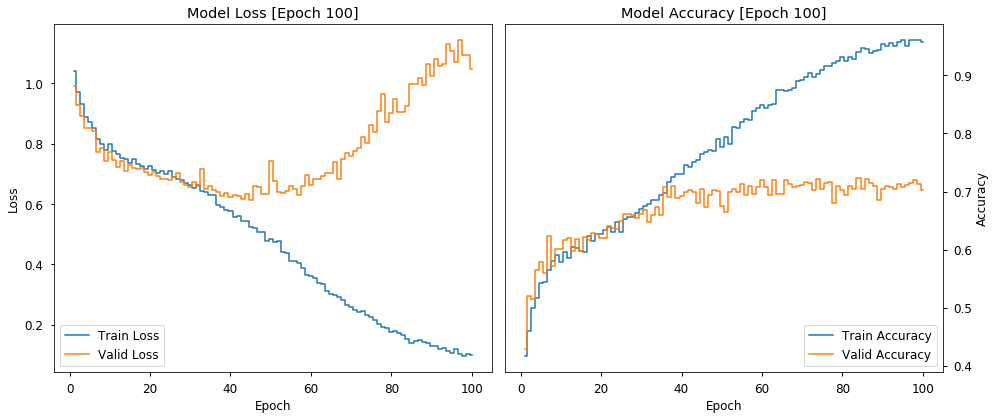

In [20]:
# Plot the training curves
plot_train_curves(H.history)

You can see here that after 50 epochs the training loss is still trending down and the training accuracy is still climbing, however, the validation accuracy curve has plateaued, and the validation loss is *increasing*. In this case  the model is starting to overfit. A flattened validation accuracy curve and a climbing training curve (i.e., diverging) is a sign of overfitting. To improve the model, we probably need to experiment with the number of hidden layers and/or their thickness. We could also 'augment' that data to increase the number of training images by, e.g., flipping the images, rotating the images etc.

Now evaluate the model's performance in numbers.

In [21]:
#this code is modified from the ANN lectorial
from sklearn.metrics import classification_report

# Predict labels for the test set
predictions = model.predict(dataTest)

# Each class is assigned a probabalilty of being correct
# so get the index of the highest probability 
yPred = predictions.argmax(axis=1)

# Compare the truth with predictions and print a report
#yTrue = testGen.classes
report = classification_report(labelsTest.argmax(axis=1),
                               yPred,
                               target_names=["cat","dog","panda"])
print(report)

              precision    recall  f1-score   support

         cat       0.65      0.70      0.68       200
         dog       0.65      0.58      0.62       200
       panda       0.83      0.86      0.85       100

    accuracy                           0.69       500
   macro avg       0.71      0.72      0.71       500
weighted avg       0.69      0.69      0.69       500



An alternative way to look visualise predictions is to make a confusion matrix. This has true labels on one axis and predicted labels on another. A perfect classifier has only entries in the diagonal meaning that all images were correctly labelled. We can pull the code used to plot the confusion matrix from the week 9 lectorial notebook.

In [22]:
#taken from Random forests lectorial -- go through in own time to understand.
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#    plt.grid(None)
#    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Normalized confusion matrix
[[0.685 0.29  0.025]
 [0.295 0.64  0.065]
 [0.05  0.1   0.85 ]]
[[137  58   5]
 [ 59 128  13]
 [  5  10  85]]


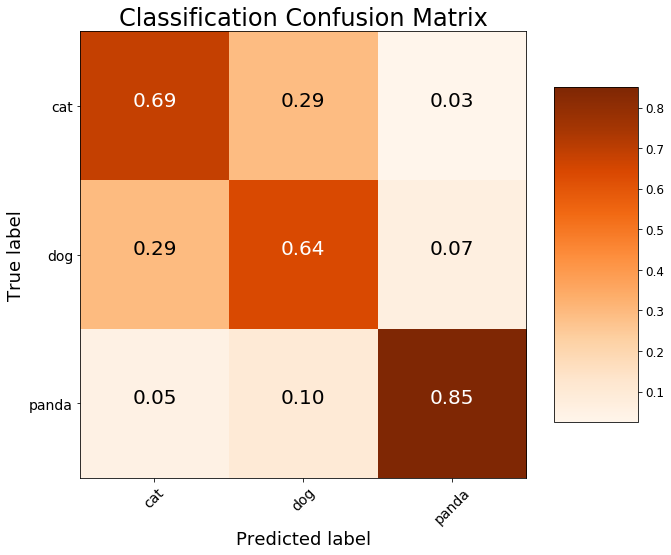

In [35]:
from sklearn.metrics import confusion_matrix
cmatrix = confusion_matrix(labelsTest.argmax(axis=1), yPred)
plot_confusion_matrix(cmatrix, classes = ['cat', 'dog', 'panda'],
                      title = 'Classification Confusion Matrix', normalize=True)
print(cmatrix)

# Using the model to make predictions

We can use the models to make a prediction for a new image. We need to load and pre-process the image. Note that the exact same steps need to be performed on the input image as we did for our training data.

In [36]:
import numpy as np

# Choose an image file to predict a label for
imageFile = "../../Complete_Tutorial_Notebooks/DATA/animals/test/cat/cat.1903.jpg"#panda/panda_00958.jpg"#dog/dog.1871.jpg"#
image = cv2.imread(imageFile)/255. #read in the image using cv2's imread and normalise
        #also use cv2 resize function to 100x100 pixel images
image_resize=cv2.resize(image,(100,100))
        #print(image.shape)
label=imageFile.split(os.path.sep)[-2]#splits the path based on the '/' separator (for unix style systems)

# The predictor is expecting a 4D array: multiple images
# in a batch (nImg, x, y, channels). We need to reshape
# our single image into a 4D array with a dummy dimension.
image = np.expand_dims(image_resize, axis=0)


In [37]:
# Process the image through the network
probs = model.predict(image)
print(probs)

labelDict=['cat', 'dog', 'panda']
# Parse the highest probability label
idx = np.argmax(probs)
predLab = labelDict[idx]
predProb = probs[0, idx]
print("\nPredicted label is {} with probability of {:.2f}".format(predLab, predProb))

[[9.8795879e-01 1.2041191e-02 1.6522026e-14]]

Predicted label is cat with probability of 0.99


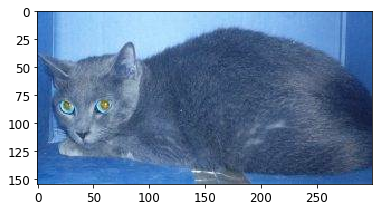

In [38]:
# Lets look at the image
plt.imshow(cv2.imread(imageFile));